In [ ]:
# emc2 WP 2 Processing 1.0 (SUBSET) - Morphometry on buildings
# Morphometry on buildings : handle missing values in building height and number of floors ; generate new indicators for building data : F (number of 
# floors), A (surface area of the building footprint), P (perimeter), E (elongation), C (convexity), FA (floor-area), ECA (elongation-convexity-area), 
# EA (elongation-area) and SW (shared walls).
# Author : Perez Joan
# Generic input data : footprint layer with attribute value height or number of floor
# emc2 input data : output from emc2 WP 2 Processing 0.1 (SUBSET)

# 0.1  Packages, local filepaths & parameters

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import numpy as np
import momepy
import libpysal

# Specify the location of subset
gpkg = "C:\\Users\\...\\WP2_DPC_06_0.1_Subset.gpkg"

# Specify the file path to record the results on the subset
gpkg_save = "C:\\Users\\...\\WP2_DPC_06_1.0_Subset.gpkg"

In [2]:
# 1  Complete NA values for building height (hauteur) and number of floors (nombre_d_etages)
# Read the data
building = gpd.read_file(gpkg, layer="building")

# fill missing height (hauteur). 'altitude_minimale_toit' : minimum roof height & 'altitude_minimale_sol' : minimum floor height
building['hauteur'] = building['hauteur'].fillna(building['altitude_minimale_toit'] - building['altitude_minimale_sol'])

# checks if the 'hauteur' column is NaN and if the 'nombre_d_etages' is not NaN.
# If both conditions are met : multiplies the value of 'nombre_d_etages' (number of floors) by 3 and assigns it to 'hauteur'
building['hauteur'] = building.apply(lambda row: row['nombre_d_etages'] * 3 if pd.isna(row['hauteur'])
                                     and not pd.isna(row['nombre_d_etages']) else row['hauteur'], axis=1)

# checks if the 'hauteur' column is NaN and if the 'nombre_d_etages' is not NaN.
# If both conditions are met : multiplies the value of 'nombre_d_etages' by 3 and assigns it to 'hauteur'
building['nombre_d_etages'] = building.apply(lambda row: round(row['hauteur'] / 3) if pd.isna(row['nombre_d_etages'])
                                             and not pd.isna(row['hauteur']) else row['nombre_d_etages'], axis=1)

print('Number of remaining values with NA for height/floors : ', building[['hauteur', 'nombre_d_etages']].isna().all(axis=1).sum())

Number of remaining values with NA for height/floors :  439


In [3]:
# 2  Morphometric indicators : Surface, Compacity, Elongation, Floor-Area - FA, Product [1-E].C.S, Product [1-E].S and Shared walls

# Number of floors
building['FL'] = building['nombre_d_etages']

# Surface
building['A'] = building.geometry.area

# Calculating perimeter
building['P'] = building.geometry.length

# Calculating elongation
building['E'] = momepy.Elongation(building).series

# Convexity
building['C'] = momepy.Convexity(building).series

# Floor area
building['FA'] = building['FL'] * building['A']

# Product [1-E].C.S
building['ECA'] = (1 - building['E']) * building['A'] * building['C']

# [1-E].S
building['EA'] = (1 - building['E']) * building['A']

# Shared walls
building["SW"] = momepy.SharedWallsRatio(building).series

In [4]:
# 3 Write a layer of buildings with morphology indicators
building.to_file(gpkg_save, layer="Buildings_with_morphology_indicators", driver="GPKG")

In [5]:
# Appendices
import contextily
import folium
from folium.plugins import MarkerCluster
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import matplotlib.pyplot as plt

<Axes: >

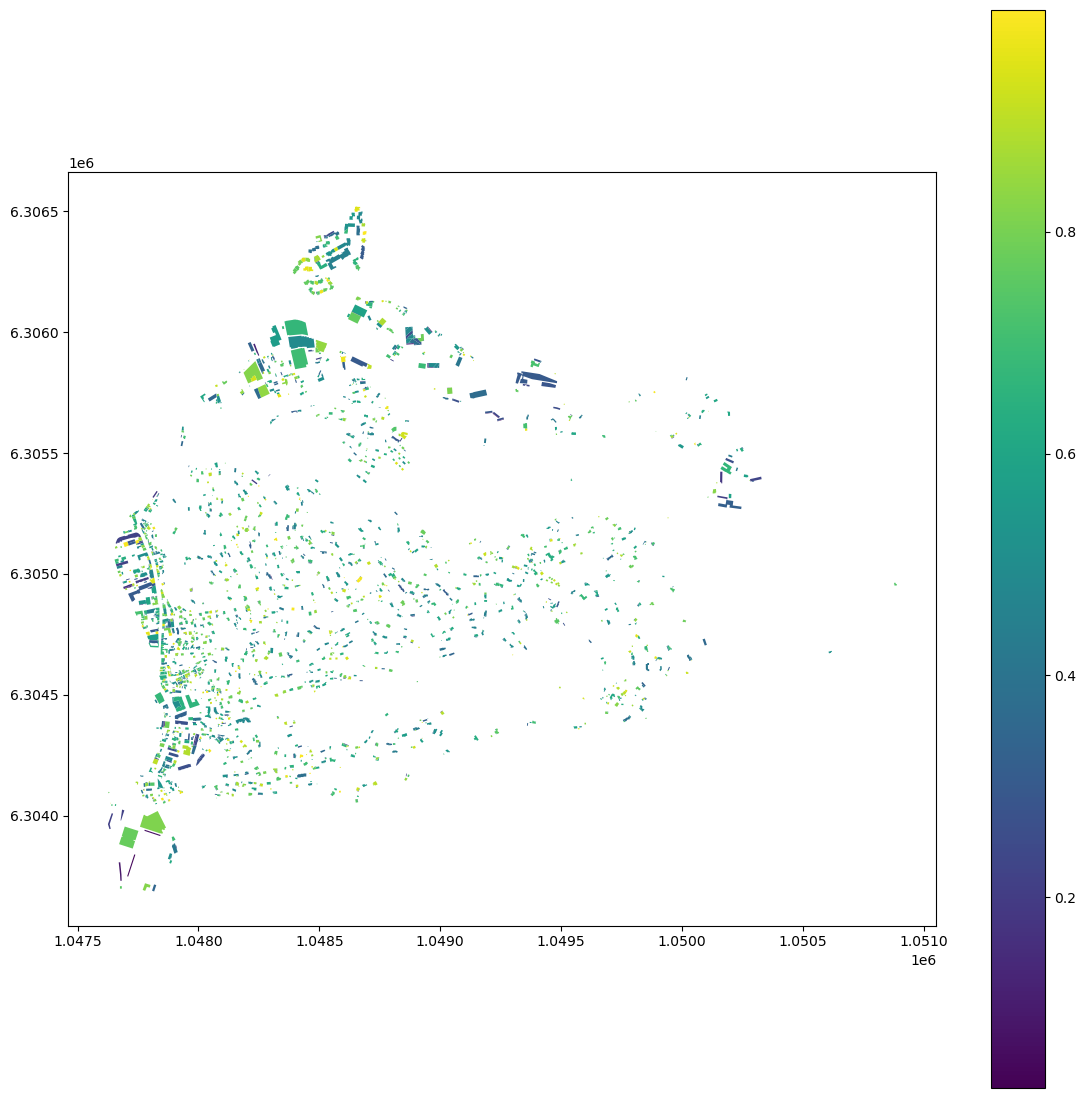

In [7]:
# Appendix A1 : Map of Elongation
building.plot(column='E', figsize=(14, 14), legend=True, cmap='viridis')

<Axes: >

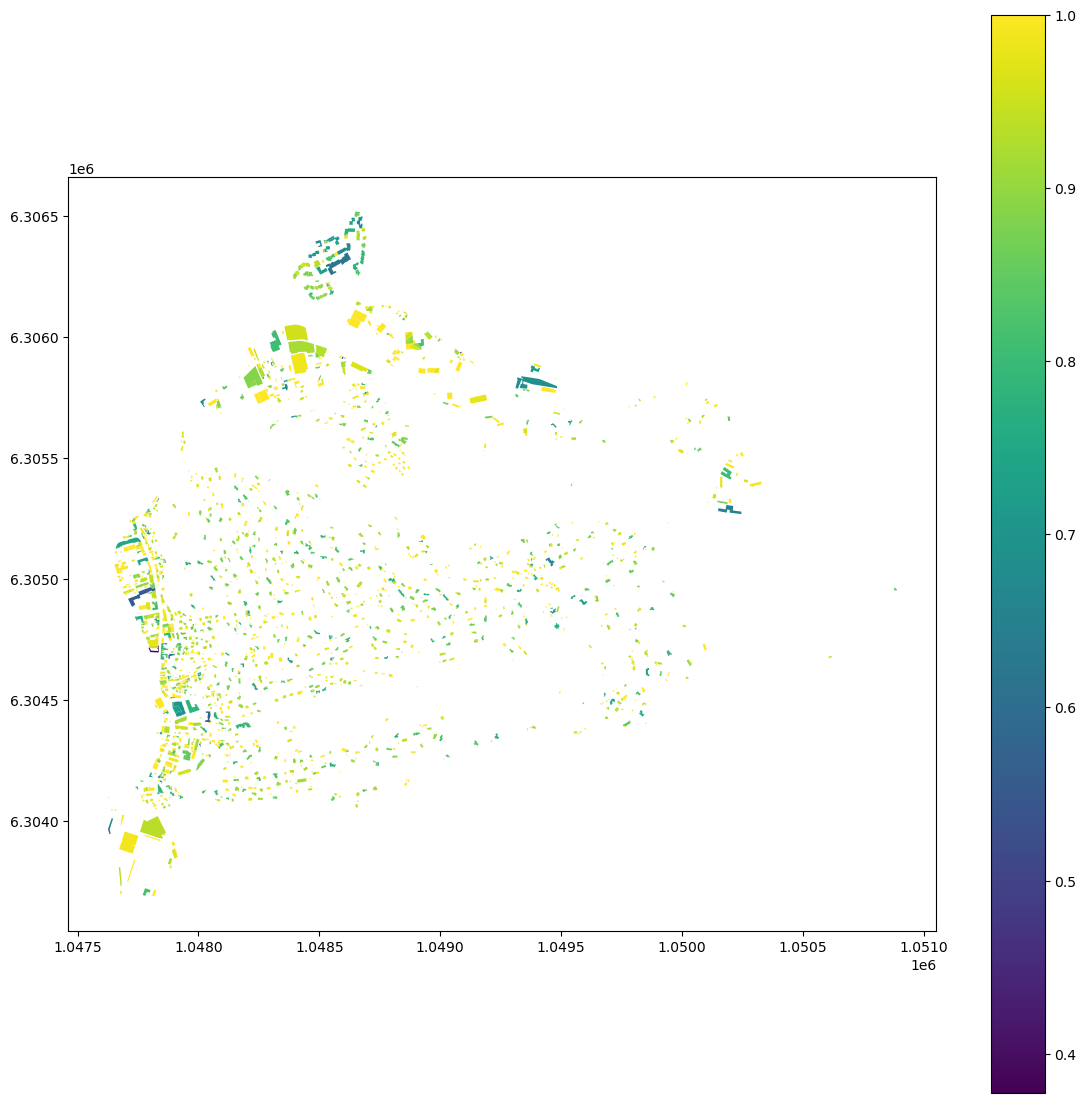

In [8]:
# Appendix A2 : Map of Convexity
building.plot(column='C', figsize=(14, 14), legend=True, cmap='viridis')

<Axes: >

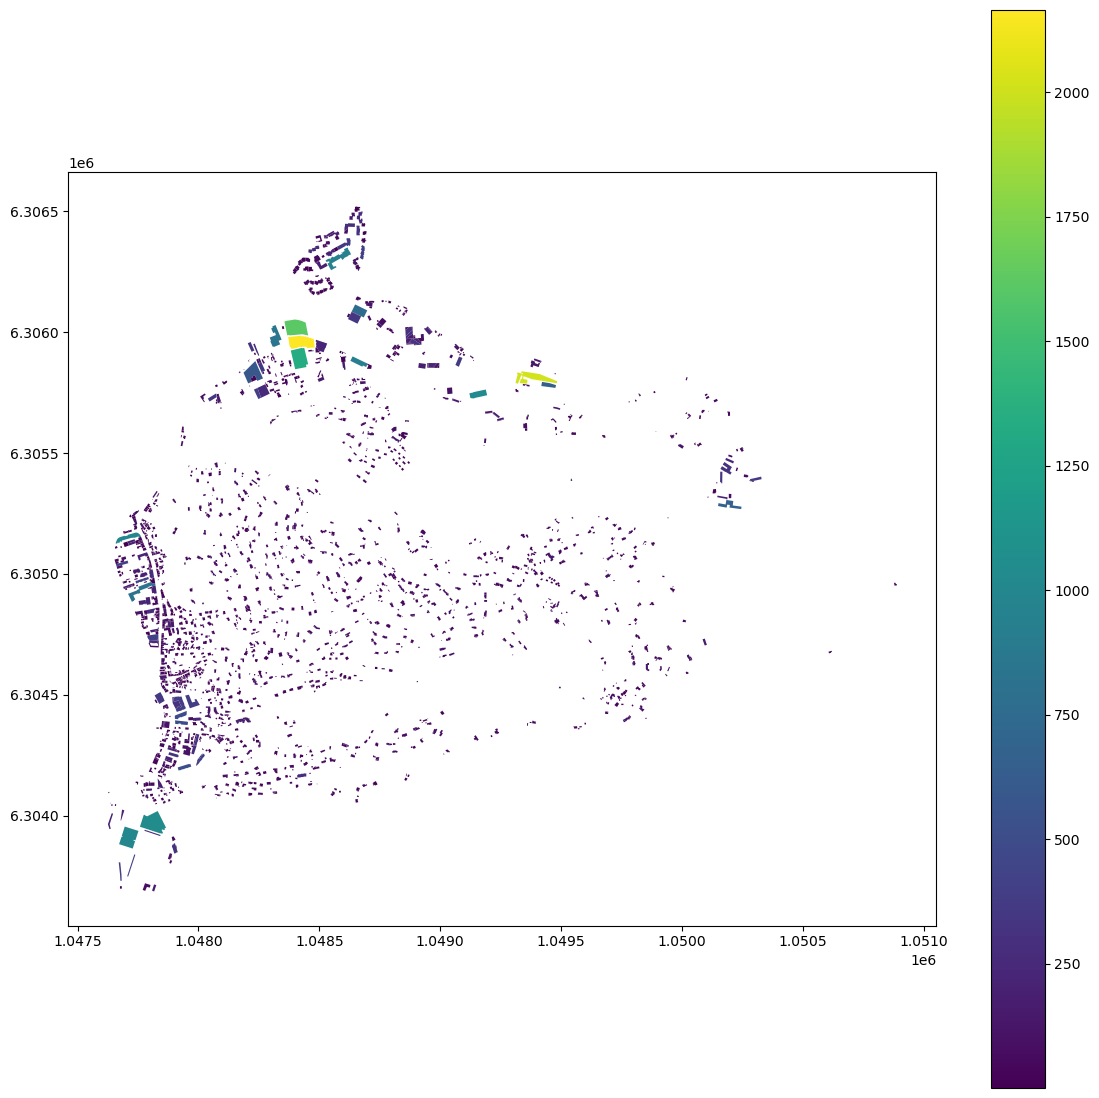

In [9]:
# Appendix A3 : Map of ECA
building.plot(column='ECA', figsize=(14, 14), legend=True, cmap='viridis')